# Predict a multi-label text value using BlazingText

## BlazingText

https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html

# Prepare the Environment

## Upgrade the version of boto3 and sagemaker

In [1]:
%pip install -qU --upgrade boto3
%pip install -qU --upgrade sagemaker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install Wordcloud

%pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import sagemaker
from sagemaker.estimator import Estimator 
from sagemaker import get_execution_role
import boto3
from sagemaker import image_uris
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
from time import gmtime, strftime
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import re

# Set column widtrh to 200 to make the text easier to read
pd.options.display.max_colwidth = 200

## Download the NTLK Trained Models

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Download the NTLK Stopwords list

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Download the NLTK corpus reader

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


True

## Setup your your Environment Variables

In [7]:
role = get_execution_role()
sess = sagemaker.Session() 
region = sess.boto_session.region_name
bucket = sess.default_bucket()
print("The role is ", role)
print("The session is ", sess)
print("The region is ", region)
print("The bucket is ", bucket)

The role is  arn:aws:iam::870427325799:role/LabRole
The session is  <sagemaker.session.Session object at 0x7f3b014ebb50>
The region is  us-east-1
The bucket is  sagemaker-us-east-1-870427325799


## We are going to use BlazingText to make predicitons based on the Twitter Financial News Dataset

## Twitter Financial News Dataset
https://www.kaggle.com/datasets/sulphatet/twitter-financial-news

### About the Data
The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their topic.

#### Label

The dataset holds 21,107 documents annotated with 20 labels:

    "LABEL_0": "Analyst Update",

    "LABEL_1": "Fed | Central Banks",

    "LABEL_2": "Company | Product News",

    "LABEL_3": "Treasuries | Corporate Debt",

    "LABEL_4": "Dividend",

    "LABEL_5": "Earnings",

    "LABEL_6": "Energy | Oil",

    "LABEL_7": "Financials",

    "LABEL_8": "Currencies",

    "LABEL_9": "General News | Opinion",

    "LABEL_10": "Gold | Metals | Materials",

    "LABEL_11": "IPO",

    "LABEL_12": "Legal | Regulation",

    "LABEL_13": "M&A | Investments",

    "LABEL_14": "Macro",

    "LABEL_15": "Markets",

    "LABEL_16": "Politics",

    "LABEL_17": "Personnel Change",

    "LABEL_18": "Stock Commentary",

    "LABEL_19": "Stock Movement"

# Prepare and Inspect the Data
## Download the Dataset to Jupyter Notebook and Explore the Data

In [8]:
# Import the data into a pandas DataFrame

twitter_data = pd.read_csv("twitter_financial_data.csv")

In [9]:
# Look at the data

twitter_data

,text,label
0,"Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more https://t.co/QPN8Gwl7Uh",0
1,"Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says https://t.co/fLS2w57iCz",0
2,"Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition https://t.co/1EmtywmYpr",0
3,"Analysts react to Tesla's latest earnings, break down what's next for electric car maker https://t.co/kwhoE6W06u",0
4,"Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside https://t.co/jPpdl0D9s4",0
...,...,...
21102,Dollar bonds of Chinese developers fall as stress spreads from junk-rated names to investment-grade peers amid renewed concerns about more Covid lockdowns https://t.co/uhSv4iiR6C,3
21103,"Longer maturity Treasury yields have scope to go higher still and the market is erring in pricing in Fed interest-rate cuts in the latter part of 2023, according to Franklin Templeton https://t.c...",3
21104,Pimco buys €1bn of Apollo buyout loans from banks https://t.co/nbgVPY34JA,3
21105,Analysis: Banks' snubbing of junk-rated loan funds worsens financing logjam https://t.co/Jl0EuExhB1 https://t.co/M8MuEzCPO1,3


In [10]:
# Lets check to see if there are any missing values

twitter_data.isnull().sum()

text     0
label    0
dtype: int64

In [11]:
# Use describe to get some information about the data

twitter_data.describe()

,label
count,21107.000000
mean,9.536031
std,6.410118
min,0.000000
25%,2.000000
50%,9.000000
75%,16.000000
max,19.000000


In [12]:
# Use the group by to see how many records there are for each label

twitter_data.groupby('label').describe()

text         \
      count unique   
label                
0       328    328   
1      1051   1051   
2      4397   4397   
3       398    398   
4       456    456   
5      1229   1229   
6       670    670   
7       784    784   
8       198    198   
9      1893   1893   
10       82     82   
11       58     58   
12      606    606   
13      587    587   
14     2237   2237   
15      626    626   
16     1234   1234   
17      607    607   
18     2646   2646   
19     1020   1020   

                                                                                                                                                                                                                \
                                                                                                                                                                                                           top   
label                                                                                                                                                                                                            
0                                                                               Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh   
1                                    LIVE: ECB surprises with 50bps hike, ending its negative rate era.   President Christine Lagarde is taking questions ▶️  https://t.co/kYTBkHyofP  https://t.co/R6mOgZnMiL   
2      Goldman Sachs traders countered the industry’s underwriting slump with revenue gains that raced past analysts’ estimates.  The trading operation posted a 32% surge in second-quarter revenue that i...   
3      China Evergrande Group’s onshore bond holders rejected a plan by the distressed developer to further extend a bond payment which was due on Friday.   Rebecca Choong Wilkins reports on Bloomberg Te...   
4                                                                                 Investing Club: Morgan Stanley's dividend, buyback pay us for our patience after quarterly missteps  https://t.co/6uFVcvkxGN   
5                                                                                             Investing Club: Our takes on Amazon and Apple heading into next week's earnings reports  https://t.co/Tfk97a4R4C   
6      JUST RELEASED: Oil Price Dynamics Report → Over the past week, oil prices decreased as supply expectations rose and anticipated demand remained unchanged.  https://t.co/abK4m2uzxo  https://t.co/0V...   
7      Delta Air Lines fell short of profit expectations in the second quarter and said high operating costs will persist through the rest of the year.   Bloomberg Opinion's Brooke Sutherland has more on...   
8                              BREAKING: The Indian rupee plummets to a record 80 per US dollar as foreign investors pull out money from the nation's stocks  https://t.co/7vY4NvnvPS  https://t.co/r05nf59krL   
9                                                                                               Twitter and Elon Musk are now in a high stakes/high risk situation, one analyst said.  https://t.co/II5sEauXAW   
10                                                                                             Copper prices are signaling that investors are bearish on the economy, strategist says  https://t.co/APwUHPn9vk   
11     Johnson &amp; Johnson CFO Joe Wolk says the company is positioned for the long term and the plans for its consumer operations include an IPO. He speaks on “Bloomberg Markets”  https://t.co/A6UdvBy...   
12     Company and Elon Musk are set for a blockbuster courtroom battle over Musk’s attempt to terminate his $44 billion acquisition deal for $TWTR, according to Wedbush analyst Dan Ives.  https://t.co/J...   
13                                                                                                    Amazon to buy primary health care prov

Creating a new column with teh label names tro create a legend

In [13]:
bar_labels = ["Analyst Update", "Fed | Central Banks", "Company | Product News", "Treasuries | Corporate Debt", "Dividend", "Earnings", "Energy | Oil", "Financials", "Currencies", "General News | Opinion",
                "Gold | Metals | Materials", "IPO", "Legal | Regulation", "M&A | Investments", "Macro", "Markets", "Politics", "Personnel Change", "Stock Commentary", "Stock Movement"]

# Create new dataframe column with the labels instead of numbers
twitter_data["label_name"] = twitter_data["label"].map(dict(zip(range(0,19), bar_labels)))

In [14]:
twitter_data

,text,label,label_name
0,"Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more https://t.co/QPN8Gwl7Uh",0,Analyst Update
1,"Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says https://t.co/fLS2w57iCz",0,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition https://t.co/1EmtywmYpr",0,Analyst Update
3,"Analysts react to Tesla's latest earnings, break down what's next for electric car maker https://t.co/kwhoE6W06u",0,Analyst Update
4,"Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside https://t.co/jPpdl0D9s4",0,Analyst Update
...,...,...,...
21102,Dollar bonds of Chinese developers fall as stress spreads from junk-rated names to investment-grade peers amid renewed concerns about more Covid lockdowns https://t.co/uhSv4iiR6C,3,Treasuries | Corporate Debt
21103,"Longer maturity Treasury yields have scope to go higher still and the market is erring in pricing in Fed interest-rate cuts in the latter part of 2023, according to Franklin Templeton https://t.c...",3,Treasuries | Corporate Debt
21104,Pimco buys €1bn of Apollo buyout loans from banks https://t.co/nbgVPY34JA,3,Treasuries | Corporate Debt
21105,Analysis: Banks' snubbing of junk-rated loan funds worsens financing logjam https://t.co/Jl0EuExhB1 https://t.co/M8MuEzCPO1,3,Treasuries | Corporate Debt


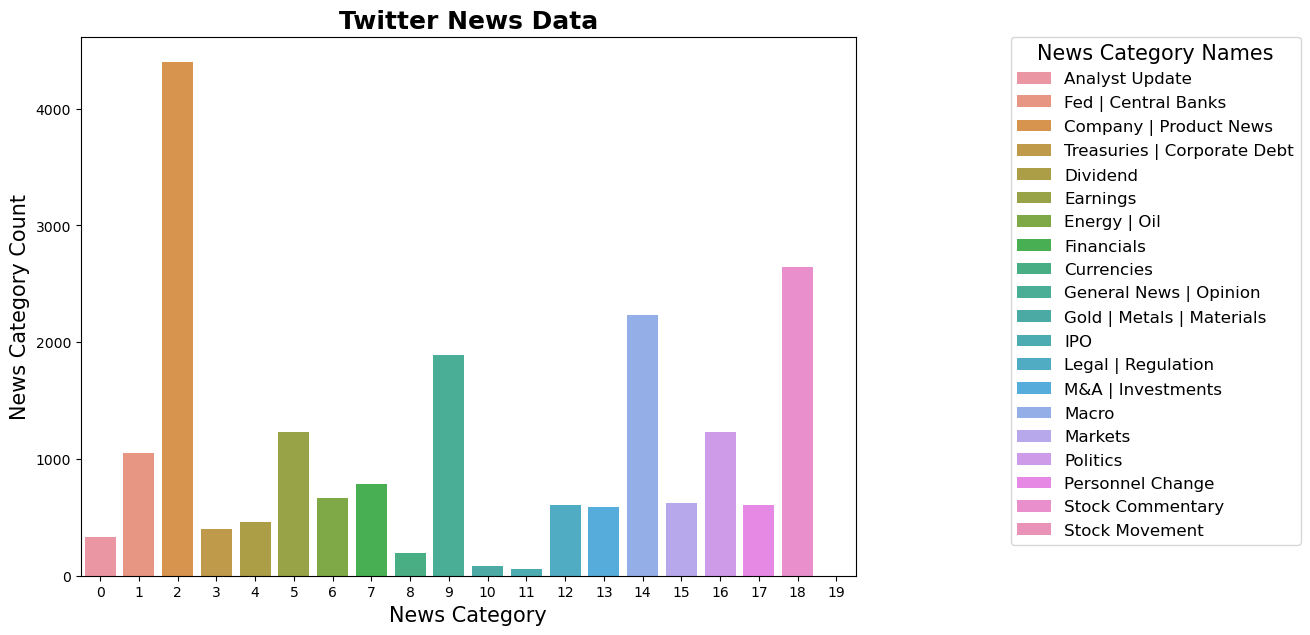

In [15]:
countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(x = 'label', data=twitter_data, hue='label_name', hue_order=bar_labels, dodge=False)

ax.set_title('Twitter News Data',fontsize = 18, fontweight='bold' )
ax.set_xlabel('News Category', fontsize = 15)
ax.set_ylabel('News Category Count', fontsize = 15)

ax.legend(fontsize = 12, bbox_to_anchor=(1.2, 1), title="News Category Names", title_fontsize = 15, loc='upper left', borderaxespad=0)

# Cleanup the data

## Convert all the text to lower case

In [16]:
twitter_data['text'] = twitter_data['text'].str.lower()
twitter_data['text']

0                                                                                 here are thursday's biggest analyst calls: apple, amazon, tesla, palantir, docusign, exxon &amp; more  https://t.co/qpn8gwl7uh
1                                                                                                                   buy las vegas sands as travel to singapore builds, wells fargo says  https://t.co/fls2w57icz
2                                                                                                  piper sandler downgrades docusign to sell, citing elevated risks amid ceo transition  https://t.co/1emtywmypr
3                                                                                              analysts react to tesla's latest earnings, break down what's next for electric car maker  https://t.co/kwhoe6w06u
4                                                                                    netflix and its peers are set for a ‘return to growth,’ analysts say, giving on

## Remove website URLs

In [17]:
twitter_data['text'] = twitter_data['text'].apply(lambda x : re.sub('http://\S+|https://\S+', '', x))

twitter_data

,text,label,label_name
0,"here are thursday's biggest analyst calls: apple, amazon, tesla, palantir, docusign, exxon &amp; more",0,Analyst Update
1,"buy las vegas sands as travel to singapore builds, wells fargo says",0,Analyst Update
2,"piper sandler downgrades docusign to sell, citing elevated risks amid ceo transition",0,Analyst Update
3,"analysts react to tesla's latest earnings, break down what's next for electric car maker",0,Analyst Update
4,"netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside",0,Analyst Update
...,...,...,...
21102,dollar bonds of chinese developers fall as stress spreads from junk-rated names to investment-grade peers amid renewed concerns about more covid lockdowns,3,Treasuries | Corporate Debt
21103,"longer maturity treasury yields have scope to go higher still and the market is erring in pricing in fed interest-rate cuts in the latter part of 2023, according to franklin templeton",3,Treasuries | Corporate Debt
21104,pimco buys €1bn of apollo buyout loans from banks,3,Treasuries | Corporate Debt
21105,analysis: banks' snubbing of junk-rated loan funds worsens financing logjam,3,Treasuries | Corporate Debt


## Remove whitespace at the front and end of the sentence

In [18]:
twitter_data['text'] = twitter_data['text'].apply(lambda x : x.strip())

twitter_data

,text,label,label_name
0,"here are thursday's biggest analyst calls: apple, amazon, tesla, palantir, docusign, exxon &amp; more",0,Analyst Update
1,"buy las vegas sands as travel to singapore builds, wells fargo says",0,Analyst Update
2,"piper sandler downgrades docusign to sell, citing elevated risks amid ceo transition",0,Analyst Update
3,"analysts react to tesla's latest earnings, break down what's next for electric car maker",0,Analyst Update
4,"netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside",0,Analyst Update
...,...,...,...
21102,dollar bonds of chinese developers fall as stress spreads from junk-rated names to investment-grade peers amid renewed concerns about more covid lockdowns,3,Treasuries | Corporate Debt
21103,"longer maturity treasury yields have scope to go higher still and the market is erring in pricing in fed interest-rate cuts in the latter part of 2023, according to franklin templeton",3,Treasuries | Corporate Debt
21104,pimco buys €1bn of apollo buyout loans from banks,3,Treasuries | Corporate Debt
21105,analysis: banks' snubbing of junk-rated loan funds worsens financing logjam,3,Treasuries | Corporate Debt


## Remove any punctuation

In [19]:
twitter_data['text'] = twitter_data['text'].apply(lambda x: x.translate (str.maketrans('', '', string.punctuation)))
    
twitter_data

,text,label,label_name
0,here are thursdays biggest analyst calls apple amazon tesla palantir docusign exxon amp more,0,Analyst Update
1,buy las vegas sands as travel to singapore builds wells fargo says,0,Analyst Update
2,piper sandler downgrades docusign to sell citing elevated risks amid ceo transition,0,Analyst Update
3,analysts react to teslas latest earnings break down whats next for electric car maker,0,Analyst Update
4,netflix and its peers are set for a ‘return to growth’ analysts say giving one stock 120 upside,0,Analyst Update
...,...,...,...
21102,dollar bonds of chinese developers fall as stress spreads from junkrated names to investmentgrade peers amid renewed concerns about more covid lockdowns,3,Treasuries | Corporate Debt
21103,longer maturity treasury yields have scope to go higher still and the market is erring in pricing in fed interestrate cuts in the latter part of 2023 according to franklin templeton,3,Treasuries | Corporate Debt
21104,pimco buys €1bn of apollo buyout loans from banks,3,Treasuries | Corporate Debt
21105,analysis banks snubbing of junkrated loan funds worsens financing logjam,3,Treasuries | Corporate Debt


## Remove any numbers

In [20]:
twitter_data['text'] = twitter_data['text'].apply(lambda x: x.translate (str.maketrans('', '', string.digits)))
    
twitter_data

,text,label,label_name
0,here are thursdays biggest analyst calls apple amazon tesla palantir docusign exxon amp more,0,Analyst Update
1,buy las vegas sands as travel to singapore builds wells fargo says,0,Analyst Update
2,piper sandler downgrades docusign to sell citing elevated risks amid ceo transition,0,Analyst Update
3,analysts react to teslas latest earnings break down whats next for electric car maker,0,Analyst Update
4,netflix and its peers are set for a ‘return to growth’ analysts say giving one stock upside,0,Analyst Update
...,...,...,...
21102,dollar bonds of chinese developers fall as stress spreads from junkrated names to investmentgrade peers amid renewed concerns about more covid lockdowns,3,Treasuries | Corporate Debt
21103,longer maturity treasury yields have scope to go higher still and the market is erring in pricing in fed interestrate cuts in the latter part of according to franklin templeton,3,Treasuries | Corporate Debt
21104,pimco buys €bn of apollo buyout loans from banks,3,Treasuries | Corporate Debt
21105,analysis banks snubbing of junkrated loan funds worsens financing logjam,3,Treasuries | Corporate Debt


## Tokenize

In [21]:
twitter_data['text'] = twitter_data['text'].apply(word_tokenize)

In [22]:
twitter_data

,text,label,label_name
0,"[here, are, thursdays, biggest, analyst, calls, apple, amazon, tesla, palantir, docusign, exxon, amp, more]",0,Analyst Update
1,"[buy, las, vegas, sands, as, travel, to, singapore, builds, wells, fargo, says]",0,Analyst Update
2,"[piper, sandler, downgrades, docusign, to, sell, citing, elevated, risks, amid, ceo, transition]",0,Analyst Update
3,"[analysts, react, to, teslas, latest, earnings, break, down, whats, next, for, electric, car, maker]",0,Analyst Update
4,"[netflix, and, its, peers, are, set, for, a, ‘, return, to, growth, ’, analysts, say, giving, one, stock, upside]",0,Analyst Update
...,...,...,...
21102,"[dollar, bonds, of, chinese, developers, fall, as, stress, spreads, from, junkrated, names, to, investmentgrade, peers, amid, renewed, concerns, about, more, covid, lockdowns]",3,Treasuries | Corporate Debt
21103,"[longer, maturity, treasury, yields, have, scope, to, go, higher, still, and, the, market, is, erring, in, pricing, in, fed, interestrate, cuts, in, the, latter, part, of, according, to, franklin,...",3,Treasuries | Corporate Debt
21104,"[pimco, buys, €bn, of, apollo, buyout, loans, from, banks]",3,Treasuries | Corporate Debt
21105,"[analysis, banks, snubbing, of, junkrated, loan, funds, worsens, financing, logjam]",3,Treasuries | Corporate Debt


## Remove Stopwords

In [23]:
stop_words = set(stopwords.words('english'))

twitter_data['text'] = twitter_data['text'].apply(lambda x: [word for word in x if word not in (stop_words)])
twitter_data

,text,label,label_name
0,"[thursdays, biggest, analyst, calls, apple, amazon, tesla, palantir, docusign, exxon, amp]",0,Analyst Update
1,"[buy, las, vegas, sands, travel, singapore, builds, wells, fargo, says]",0,Analyst Update
2,"[piper, sandler, downgrades, docusign, sell, citing, elevated, risks, amid, ceo, transition]",0,Analyst Update
3,"[analysts, react, teslas, latest, earnings, break, whats, next, electric, car, maker]",0,Analyst Update
4,"[netflix, peers, set, ‘, return, growth, ’, analysts, say, giving, one, stock, upside]",0,Analyst Update
...,...,...,...
21102,"[dollar, bonds, chinese, developers, fall, stress, spreads, junkrated, names, investmentgrade, peers, amid, renewed, concerns, covid, lockdowns]",3,Treasuries | Corporate Debt
21103,"[longer, maturity, treasury, yields, scope, go, higher, still, market, erring, pricing, fed, interestrate, cuts, latter, part, according, franklin, templeton]",3,Treasuries | Corporate Debt
21104,"[pimco, buys, €bn, apollo, buyout, loans, banks]",3,Treasuries | Corporate Debt
21105,"[analysis, banks, snubbing, junkrated, loan, funds, worsens, financing, logjam]",3,Treasuries | Corporate Debt


## Lemmatize Words


In [24]:
word_lemmatizer = WordNetLemmatizer()

twitter_data['text'] = twitter_data['text'].apply(lambda x: [word_lemmatizer.lemmatize(word) for word in x])
twitter_data

,text,label,label_name
0,"[thursday, biggest, analyst, call, apple, amazon, tesla, palantir, docusign, exxon, amp]",0,Analyst Update
1,"[buy, la, vega, sand, travel, singapore, build, well, fargo, say]",0,Analyst Update
2,"[piper, sandler, downgrade, docusign, sell, citing, elevated, risk, amid, ceo, transition]",0,Analyst Update
3,"[analyst, react, tesla, latest, earnings, break, whats, next, electric, car, maker]",0,Analyst Update
4,"[netflix, peer, set, ‘, return, growth, ’, analyst, say, giving, one, stock, upside]",0,Analyst Update
...,...,...,...
21102,"[dollar, bond, chinese, developer, fall, stress, spread, junkrated, name, investmentgrade, peer, amid, renewed, concern, covid, lockdown]",3,Treasuries | Corporate Debt
21103,"[longer, maturity, treasury, yield, scope, go, higher, still, market, erring, pricing, fed, interestrate, cut, latter, part, according, franklin, templeton]",3,Treasuries | Corporate Debt
21104,"[pimco, buy, €bn, apollo, buyout, loan, bank]",3,Treasuries | Corporate Debt
21105,"[analysis, bank, snubbing, junkrated, loan, fund, worsens, financing, logjam]",3,Treasuries | Corporate Debt


## Convert list back to sentences

In [25]:
twitter_data['text'] = twitter_data['text'].apply(lambda x: ' '.join(x))
twitter_data

,text,label,label_name
0,thursday biggest analyst call apple amazon tesla palantir docusign exxon amp,0,Analyst Update
1,buy la vega sand travel singapore build well fargo say,0,Analyst Update
2,piper sandler downgrade docusign sell citing elevated risk amid ceo transition,0,Analyst Update
3,analyst react tesla latest earnings break whats next electric car maker,0,Analyst Update
4,netflix peer set ‘ return growth ’ analyst say giving one stock upside,0,Analyst Update
...,...,...,...
21102,dollar bond chinese developer fall stress spread junkrated name investmentgrade peer amid renewed concern covid lockdown,3,Treasuries | Corporate Debt
21103,longer maturity treasury yield scope go higher still market erring pricing fed interestrate cut latter part according franklin templeton,3,Treasuries | Corporate Debt
21104,pimco buy €bn apollo buyout loan bank,3,Treasuries | Corporate Debt
21105,analysis bank snubbing junkrated loan fund worsens financing logjam,3,Treasuries | Corporate Debt


## Create Word Cloud

In [26]:
text = " ".join(review for review in twitter_data['text'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 1754366 words in the combination of all review.


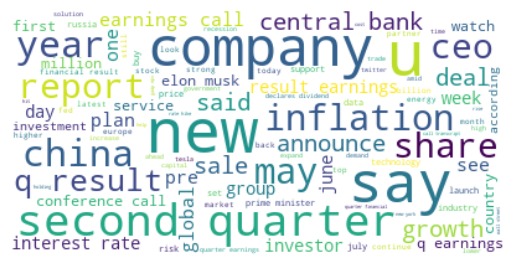

In [27]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Drop the additional column made

In [28]:
twitter_data = twitter_data.drop('label_name', axis=1)
twitter_data

,text,label
0,thursday biggest analyst call apple amazon tesla palantir docusign exxon amp,0
1,buy la vega sand travel singapore build well fargo say,0
2,piper sandler downgrade docusign sell citing elevated risk amid ceo transition,0
3,analyst react tesla latest earnings break whats next electric car maker,0
4,netflix peer set ‘ return growth ’ analyst say giving one stock upside,0
...,...,...
21102,dollar bond chinese developer fall stress spread junkrated name investmentgrade peer amid renewed concern covid lockdown,3
21103,longer maturity treasury yield scope go higher still market erring pricing fed interestrate cut latter part according franklin templeton,3
21104,pimco buy €bn apollo buyout loan bank,3
21105,analysis bank snubbing junkrated loan fund worsens financing logjam,3


## Add the _ _ LABEL _ _ Prefix to the labels

In [29]:
# Concatenate __label__ with twitter['Category'] 

# label is numeric so convert to string
twitter_data['label'] = twitter_data['label'].astype('string')

twitter_data['label'] = "__label__" + twitter_data['label']
twitter_data

,text,label
0,thursday biggest analyst call apple amazon tesla palantir docusign exxon amp,__label__0
1,buy la vega sand travel singapore build well fargo say,__label__0
2,piper sandler downgrade docusign sell citing elevated risk amid ceo transition,__label__0
3,analyst react tesla latest earnings break whats next electric car maker,__label__0
4,netflix peer set ‘ return growth ’ analyst say giving one stock upside,__label__0
...,...,...
21102,dollar bond chinese developer fall stress spread junkrated name investmentgrade peer amid renewed concern covid lockdown,__label__3
21103,longer maturity treasury yield scope go higher still market erring pricing fed interestrate cut latter part according franklin templeton,__label__3
21104,pimco buy €bn apollo buyout loan bank,__label__3
21105,analysis bank snubbing junkrated loan fund worsens financing logjam,__label__3


In [30]:
# Shuffle and Split the data into 80% training and 20% validating

train_data, validate_data = train_test_split(twitter_data, test_size=0.2)

# Convert dataframes to TEXT files and save them locally to the notebook and make sure to exclude the headers so that BlazingText will accept the file

train_data.to_csv('twitter_data.train', sep=' ', header=False, index=False, quotechar=" ")
validate_data.to_csv('twitter_data.validate', sep=' ', header=False, index=False, quotechar=" ")

In [31]:
# Copy the file to your S3 bucket using sess.upload_data
# You will need to pass the file to be uploaded, a prefix (top level folder to store the data) and the subfolders
# Here we will also define the output folder for the results
# Note I did not call them .csv because the are not csv files but text files

prefix = 'twitter_news'
training_data_path = sess.upload_data( path='twitter_data.train', key_prefix=prefix + '/input/train') 
validation_data_path = sess.upload_data( path='twitter_data.validate', key_prefix=prefix + '/input/validate')
output_data_path = 's3://{}/{}/output'.format(bucket, prefix)
print(training_data_path)
print(validation_data_path)
print(output_data_path)

s3://sagemaker-us-east-1-870427325799/twitter_news/input/train/twitter_data.train
s3://sagemaker-us-east-1-870427325799/twitter_news/input/validate/twitter_data.validate
s3://sagemaker-us-east-1-870427325799/twitter_news/output


In [32]:
# Create the training container

container = image_uris.retrieve(framework='blazingtext',region=region)

In [33]:
# Create your data channels

train_data = sagemaker.inputs.TrainingInput(
    training_data_path,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validate_data = sagemaker.inputs.TrainingInput(
    validation_data_path,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validate_data}

In [34]:
# Here we are using the only required hyperameter and everything else will be set to default

bt_model = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=output_data_path,
    hyperparameters={
        "mode": "supervised"
    },
)

In [35]:
# Train the model

bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2023-03-09-12-19-48-813


2023-03-09 12:19:48 Starting - Starting the training job...
2023-03-09 12:20:06 Starting - Preparing the instances for training......
2023-03-09 12:20:54 Downloading - Downloading input data...
2023-03-09 12:21:49 Training - Training image download completed. Training in progress...Arguments: train
[03/09/2023 12:21:54 WARNING 139632368498496] Loggers have already been setup.
[03/09/2023 12:21:54 WARNING 139632368498496] Loggers have already been setup.
[03/09/2023 12:21:54 INFO 139632368498496] nvidia-smi took: 0.02521824836730957 secs to identify 0 gpus
[03/09/2023 12:21:54 INFO 139632368498496] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[03/09/2023 12:21:54 INFO 139632368498496] Processing /opt/ml/input/data/train/twitter_data.train . File size: 1.738835334777832 MB
[03/09/2023 12:21:54 INFO 139632368498496] Processing /opt/ml/input/data/validation/twitter_data.validate . File size: 0.4384899139404297 MB
Read 

# Deploy the model (no tuning)
## Here we are going to deploy the model so that we can make some inferences

In [36]:
# Retrieve model data from training job

training_job_model_data = bt_model.model_data
training_job_model_data

's3://sagemaker-us-east-1-870427325799/twitter_news/output/blazingtext-2023-03-09-12-19-48-813/output/model.tar.gz'

In [37]:
# Create a unique model name so it won't overwrite ones taht are already there using date and time

deployed_BlazingText_model_name = "twitter-no-tune-bt-model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name is " + deployed_BlazingText_model_name)

Model name is twitter-no-tune-bt-model2023-03-09-12-24-40


In [38]:
# Container Definition https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ContainerDefinition.html

client = boto3.client(service_name="sagemaker")

create_model_response = client.create_model(
    ModelName=deployed_BlazingText_model_name,
    Containers=[
        {
            "Image": container, # use the same container defined in the estimator
            "ModelDataUrl": training_job_model_data
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Model Arn: arn:aws:sagemaker:us-east-1:870427325799:model/twitter-no-tune-bt-model2023-03-09-12-24-40


In [39]:
# Create the endpoint configuration

twitter_epc_name = "blazingtext-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=twitter_epc_name,
    ProductionVariants=[
        {
            "VariantName": "btVariant",
            "ModelName": deployed_BlazingText_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:870427325799:endpoint-config/blazingtext-serverless-epc2023-03-09-12-24-41


In [40]:
# Create the endpoint response

twitter_ep_name = "twitter-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=twitter_ep_name,
    EndpointConfigName=twitter_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:870427325799:endpoint/twitter-serverless-ep2023-03-09-12-24-41


In [41]:
# Wait for endpoint to reach a terminal state (InService) using describe endpoint

describe_endpoint_response = client.describe_endpoint(EndpointName=twitter_ep_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=twitter_ep_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'twitter-serverless-ep2023-03-09-12-24-41',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:870427325799:endpoint/twitter-serverless-ep2023-03-09-12-24-41',
 'EndpointConfigName': 'blazingtext-serverless-epc2023-03-09-12-24-41',
 'ProductionVariants': [{'VariantName': 'btVariant',
   'DeployedImages': [{'SpecifiedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1',
     'ResolvedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext@sha256:f4a2d23762e88d6b992495a9a6384fd64f819fcbc2e143d8af222637ed6822ff',
     'ResolutionTime': datetime.datetime(2023, 3, 9, 12, 24, 42, 641000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 3, 9, 12, 24, 42, 55000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 3, 9, 12, 26, 25, 353000, tzinfo

In [42]:
# First sentence Label 0
# Second Sentence Label 2

sentences = ["Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh",
             "Ford just unveiled the F-150 Raptor R, a new version of its high-performance, off-road pickup with a supercharged 5.2-liter V-8 engine that produces 700 horsepower and 640 foot-pounds of torque. Take a look:  https://t.co/4srERXe88q  https://t.co/YLVa6RKCEe"]             

In [43]:
runtime = boto3.Session().client('sagemaker-runtime')

payload = {"instances": sentences}

response = runtime.invoke_endpoint(
    EndpointName=twitter_ep_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)

output = json.loads(response['Body'].read().decode('utf-8'))

print(output)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


[{'label': ['__label__2'], 'prob': [0.11956427991390228]}, {'label': ['__label__2'], 'prob': [0.15447886288166046]}]


# Cleanup the data

In [44]:
# Convert List to Dataframe

twitter_sentences = pd.DataFrame(sentences)
twitter_sentences.columns = ['text']
twitter_sentences = twitter_sentences.astype('string') #Make senteces lowercase

# Transform the sentences as we did with teh training data

twitter_sentences['text'] = twitter_sentences['text'].str.lower() # Make senteces lowercase

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x : re.sub('http://\S+|https://\S+', '', x)) # Remove URLs

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x : x.strip()) # Remove white space at the beginign and end

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: x.translate (str.maketrans('', '', string.punctuation))) # Remove punctuation

twitter_sentences['text'] = twitter_sentences['text'].apply(word_tokenize) # Tokenize the sentences

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: [word for word in x if word not in (stop_words)]) # Remove the stopwords

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: [word_lemmatizer.lemmatize(word) for word in x])

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: ' '.join(x))

new_sentences = twitter_sentences['text'].values.tolist()

new_sentences

['thursday biggest analyst call apple amazon tesla palantir docusign exxon amp',
 'ford unveiled f150 raptor r new version highperformance offroad pickup supercharged 52liter v8 engine produce 700 horsepower 640 footpounds torque take look']

In [45]:
payload = {"instances": new_sentences}

response = runtime.invoke_endpoint(
    EndpointName=twitter_ep_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)

output = json.loads(response['Body'].read().decode('utf-8'))

print(output)

[{'label': ['__label__2'], 'prob': [0.2289547175168991]}, {'label': ['__label__2'], 'prob': [0.26644113659858704]}]


In [46]:
# Delete the endpoint

# client.delete_endpoint_config(EndpointConfigName=twitter_epc_name)
# client.delete_endpoint(EndpointName=twitter_ep_name)

## Hyperparameter Tuning

In [47]:
# Here we are using the only required hyperameter and everything else will be set to default

bt_model = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=output_data_path,
    hyperparameters={
        "mode": "supervised"
    },
)

In [48]:
# The BlazingText Text Classification algorithm (supervised mode), also reports on a single metric during training: the validation:accuracy.

from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hypertuner = HyperparameterTuner(bt_model, 
                                 objective_metric_name = 'validation:accuracy',
                                 hyperparameter_ranges = {
                                 'epochs' : CategoricalParameter([1,3,5]),
                                 'min_count' : CategoricalParameter([1,3,5]),
                                 'learning_rate' : ContinuousParameter(0.01, 0.1),
                                 'batch_size': CategoricalParameter([32,64,128,256,512])},   
                                 objective_type = 'Maximize',
                                 metric_definitions = [{'Name': 'validation:accuracy', 'Regex': 'loss (\S+)'}],
                                 max_jobs=10, 
                                 max_parallel_jobs=1
                                )


In [49]:
# Start the training and tuning

hypertuner.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating hyperparameter tuning job with name: blazingtext-230309-1226


...............................................................................................................................................................................................................................................................................................................................................................!


In [50]:
# Print out the best parameters the tuning job found

print("Best hyerparameter tuning job:{}".format(hypertuner.best_training_job()))
print("Best parameters found={}".format(hypertuner.best_estimator().hyperparameters()))

Best hyerparameter tuning job:blazingtext-230309-1226-003-953d86ca

2023-03-09 12:36:43 Starting - Found matching resource for reuse
2023-03-09 12:36:43 Downloading - Downloading input data
2023-03-09 12:36:43 Training - Training image download completed. Training in progress.
2023-03-09 12:36:43 Uploading - Uploading generated training model
2023-03-09 12:36:43 Completed - Resource reused by training job: blazingtext-230309-1226-004-4bc9a058
Best parameters found={'_tuning_objective_metric': 'validation:accuracy', 'batch_size': '256', 'epochs': '5', 'learning_rate': '0.0768564102201141', 'min_count': '1', 'mode': 'supervised'}


In [51]:
# Confirgure the model with the parameters that were printed

bt_model = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=output_data_path,
    hyperparameters={
        "mode": "supervised",
        "batch_size": 32,
        "epochs": 5,
        "learning_rate": 0.09869630055892538,
        "min_count": 3
    },
)

In [52]:
# Train the model

bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2023-03-09-12-56-54-946


2023-03-09 12:56:55 Starting - Starting the training job............
2023-03-09 12:58:44 Starting - Preparing the instances for training...
2023-03-09 12:59:25 Downloading - Downloading input data......
2023-03-09 13:00:00 Training - Downloading the training image...
2023-03-09 13:00:44 Training - Training image download completed. Training in progress.Arguments: train
[03/09/2023 13:00:47 WARNING 140332353386304] Loggers have already been setup.
[03/09/2023 13:00:47 WARNING 140332353386304] Loggers have already been setup.
[03/09/2023 13:00:47 INFO 140332353386304] nvidia-smi took: 0.02520895004272461 secs to identify 0 gpus
[03/09/2023 13:00:47 INFO 140332353386304] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[03/09/2023 13:00:47 INFO 140332353386304] Processing /opt/ml/input/data/train/twitter_data.train . File size: 1.738835334777832 MB
[03/09/2023 13:00:47 INFO 140332353386304] Processing /opt/ml/input/data/v

# Deploy the model (with tuning)
## Here we are going to deploy the model so that we can make some inferences

In [53]:
# Retrieve model data from training job

training_job_model_data = bt_model.model_data
training_job_model_data

's3://sagemaker-us-east-1-870427325799/twitter_news/output/blazingtext-2023-03-09-12-56-54-946/output/model.tar.gz'

In [54]:
# Create a unique model name so it won't overwrite ones taht are already there using date and time
deployed_BlazingText_model_name = "twitter-bt-model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name is " + deployed_BlazingText_model_name)

Model name is twitter-bt-model2023-03-09-13-03-16


In [55]:
# Container Definition https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ContainerDefinition.html

client = boto3.client(service_name="sagemaker")

create_model_response = client.create_model(
    ModelName=deployed_BlazingText_model_name,
    Containers=[
        {
            "Image": container, # use the same container defined in the estimator
            "ModelDataUrl": training_job_model_data
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:870427325799:model/twitter-bt-model2023-03-09-13-03-16


In [56]:
twitter_epc_name = "blazingtext-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=twitter_epc_name,
    ProductionVariants=[
        {
            "VariantName": "btVariant",
            "ModelName": deployed_BlazingText_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:870427325799:endpoint-config/blazingtext-serverless-epc2023-03-09-13-03-17


In [57]:
twitter_ep_name = "twitter-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=twitter_ep_name,
    EndpointConfigName=twitter_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:870427325799:endpoint/twitter-serverless-ep2023-03-09-13-03-17


In [58]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint

import time

describe_endpoint_response = client.describe_endpoint(EndpointName=twitter_ep_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=twitter_ep_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'twitter-serverless-ep2023-03-09-13-03-17',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:870427325799:endpoint/twitter-serverless-ep2023-03-09-13-03-17',
 'EndpointConfigName': 'blazingtext-serverless-epc2023-03-09-13-03-17',
 'ProductionVariants': [{'VariantName': 'btVariant',
   'DeployedImages': [{'SpecifiedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1',
     'ResolvedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext@sha256:f4a2d23762e88d6b992495a9a6384fd64f819fcbc2e143d8af222637ed6822ff',
     'ResolutionTime': datetime.datetime(2023, 3, 9, 13, 3, 18, 155000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 4096, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 3, 9, 13, 3, 17, 581000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 3, 9, 13, 5, 0, 574000, tzinfo=tz

In [59]:
# First sentence Label 0
# Second Sentence Label 2

sentences = ["Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh",
             "Ford just unveiled the F-150 Raptor R, a new version of its high-performance, off-road pickup with a supercharged 5.2-liter V-8 engine that produces 700 horsepower and 640 foot-pounds of torque. Take a look:  https://t.co/4srERXe88q  https://t.co/YLVa6RKCEe"]                 

In [60]:
runtime = boto3.Session().client('sagemaker-runtime')

payload = {"instances": sentences}

response = runtime.invoke_endpoint(
    EndpointName=twitter_ep_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)

output = json.loads(response['Body'].read().decode('utf-8'))

print(output)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


[{'label': ['__label__17'], 'prob': [0.10960441082715988]}, {'label': ['__label__2'], 'prob': [0.21533791720867157]}]


# Cleanup the data

In [61]:
# Convert List to Dataframe

twitter_sentences = pd.DataFrame(sentences)
twitter_sentences.columns = ['text']
twitter_sentences = twitter_sentences.astype('string') #Make senteces lowercase

# Transform the sentences as we did with teh training data

twitter_sentences['text'] = twitter_sentences['text'].str.lower() # Make senteces lowercase

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x : re.sub('http://\S+|https://\S+', '', x)) # Remove URLs

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x : x.strip()) # Remove white space at the beginign and end

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: x.translate (str.maketrans('', '', string.punctuation))) # Remove punctuation

twitter_sentences['text'] = twitter_sentences['text'].apply(word_tokenize) # Tokenize the sentences

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: [word for word in x if word not in (stop_words)]) # Remove the stopwords

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: [word_lemmatizer.lemmatize(word) for word in x])

twitter_sentences['text'] = twitter_sentences['text'].apply(lambda x: ' '.join(x))

new_sentences = twitter_sentences['text'].values.tolist()

new_sentences

['thursday biggest analyst call apple amazon tesla palantir docusign exxon amp',
 'ford unveiled f150 raptor r new version highperformance offroad pickup supercharged 52liter v8 engine produce 700 horsepower 640 footpounds torque take look']

In [62]:
payload = {"instances": new_sentences}

response = runtime.invoke_endpoint(
    EndpointName=twitter_ep_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)

output = json.loads(response['Body'].read().decode('utf-8'))

print(output)

[{'label': ['__label__2'], 'prob': [0.3209604322910309]}, {'label': ['__label__2'], 'prob': [0.6337446570396423]}]


# Cleanup the data

In [63]:
# Delete the endpoint

# client.delete_model(ModelName=deployed_BlazingText_model_name)
# client.delete_endpoint_config(EndpointConfigName=twitter_epc_name)
# client.delete_endpoint(EndpointName=twitter_ep_name)